In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import nltk
# !pip install geopy
nltk.download('stopwords')
from nltk.corpus import stopwords
from scipy.stats import skewnorm
from matplotlib import pyplot as plt
import seaborn as sbs
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from numpy import mean, std
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
#import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
# !pip install xgboost
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import geopy
# !pip install textblob
from textblob import TextBlob
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tsreelekha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading the dataset

In [2]:
AirBnb = pd.read_csv("C://Users//tsreelekha//Downloads//AirBnb//train.csv")
AirBnbTest = pd.read_csv("C://Users//tsreelekha//Downloads//AirBnb//test.csv")

Dropping ID columns

In [3]:
Y = AirBnb["log_price"]
X = AirBnb.drop(["id","log_price","name","thumbnail_url"],axis = 1)
AirBnbTest_X = AirBnbTest.drop(["id","name","thumbnail_url"],axis = 1)

In [4]:
# X,testMainX,Y,testMainY = train_test_split(FullX,FullY,test_size = 0.65, random_state = 100)

Function to get zipcode based on longitude and latitude

In [5]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']
geolocator = geopy.Nominatim(user_agent='NewTest')

Checking if the number is float

In [6]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

Applying get_zipcode function to get all the missing zipcodes

In [7]:
for i, col in enumerate(X['zipcode']):
    if pd.isna(str(X['zipcode'].iloc[i])) or (not isfloat(str(X['zipcode'].iloc[i]))):
        
        df = pd.DataFrame({
    'Lat': [X['latitude'].iloc[i]],
    'Lon': [X['longitude'].iloc[i]]})
        if df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0].get('postcode'):
            X['zipcode'].iloc[i] = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0]['postcode']
            X['zipcode'].iloc[i] = re.sub('[^0-9]', '', X['zipcode'].iloc[i])
    elif (math.isnan(float(X['zipcode'].iloc[i]))):
        df = pd.DataFrame({
    'Lat': [X['latitude'].iloc[i]],
    'Lon': [X['longitude'].iloc[i]]})
        if df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0].get('postcode'):
            X['zipcode'].iloc[i] = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0]['postcode']
            X['zipcode'].iloc[i] = re.sub('[^0-9]', '', X['zipcode'].iloc[i])
    if((not math.isnan(float(X['zipcode'].iloc[i]))) and isfloat(str(X['zipcode'].iloc[i]))):
        X['zipcode'].iloc[i] = int(float(X['zipcode'].iloc[i]))

In [8]:
for i, col in enumerate(AirBnbTest_X['zipcode']):
    if pd.isna(str(AirBnbTest_X['zipcode'].iloc[i])) or (not isfloat(str(AirBnbTest_X['zipcode'].iloc[i]))):
        df = pd.DataFrame({
    'Lat': AirBnbTest_X['latitude'].iloc[i],
    'Lon': [AirBnbTest_X['longitude'].iloc[i]]})
        if df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0].get('postcode'):
            AirBnbTest_X['zipcode'].iloc[i] = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0]['postcode']
            AirBnbTest_X['zipcode'].iloc[i] = re.sub('[^0-9]', '', AirBnbTest_X['zipcode'].iloc[i])
    elif (math.isnan(float(AirBnbTest_X['zipcode'].iloc[i]))):
        df = pd.DataFrame({
    'Lat': [AirBnbTest_X['latitude'].iloc[i]],
    'Lon': [AirBnbTest_X['longitude'].iloc[i]]})
        if df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0].get('postcode'):
            AirBnbTest_X['zipcode'].iloc[i] = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Lat', lon_field='Lon')[0]['postcode']
            AirBnbTest_X['zipcode'].iloc[i] = re.sub('[^0-9]', '', AirBnbTest_X['zipcode'].iloc[i])
    if((not math.isnan(float(AirBnbTest_X['zipcode'].iloc[i]))) and isfloat(str(AirBnbTest_X['zipcode'].iloc[i]))):
        AirBnbTest_X['zipcode'].iloc[i] = int(float(AirBnbTest_X['zipcode'].iloc[i]))

Filling neighbourhood values based on zipcodes and city

In [9]:
for i, col in enumerate(X['neighbourhood']):
    if pd.isna(X['neighbourhood'].iloc[i]):
        if len(X[(X['zipcode'].iloc[i] == X['zipcode']) & (X['city'].iloc[i] == X['city'])].neighbourhood.mode(dropna = True)) > 0:
            X['neighbourhood'].iloc[i] = X[(X['zipcode'].iloc[i] == X['zipcode']) & (X['city'].iloc[i] == X['city'])].neighbourhood.mode(dropna = True)[0]
        elif len(X[X['zipcode'].iloc[i] == X['zipcode']].neighbourhood.mode(dropna = True)) > 0:
            X['neighbourhood'].iloc[i] = X[X['zipcode'].iloc[i] == X['zipcode']].neighbourhood.mode(dropna = True)[0]
        else:
            X['neighbourhood'].iloc[i] = X[X['city'].iloc[i] == X['city']].neighbourhood.mode(dropna = True)[0]

In [10]:
for i, col in enumerate(AirBnbTest_X['neighbourhood']):
    if pd.isna(AirBnbTest_X['neighbourhood'].iloc[i]):
        if len(AirBnbTest_X[(AirBnbTest_X['zipcode'].iloc[i] ==AirBnbTest_X['zipcode']) & (AirBnbTest_X['city'].iloc[i] == AirBnbTest_X['city'])].neighbourhood.mode(dropna = True)) > 0:
            AirBnbTest_X['neighbourhood'].iloc[i] = AirBnbTest_X[(AirBnbTest_X['zipcode'].iloc[i] == AirBnbTest_X['zipcode']) & (AirBnbTest_X['city'].iloc[i] == AirBnbTest_X['city'])].neighbourhood.mode(dropna = True)[0]
        elif len(AirBnbTest_X[AirBnbTest_X['zipcode'].iloc[i] == AirBnbTest_X['zipcode']].neighbourhood.mode(dropna = True)) > 0:
            AirBnbTest_X['neighbourhood'].iloc[i] = AirBnbTest_X[AirBnbTest_X['zipcode'].iloc[i] == AirBnbTest_X['zipcode']].neighbourhood.mode(dropna = True)[0]
        else:
            AirBnbTest_X['neighbourhood'].iloc[i] = AirBnbTest_X[AirBnbTest_X['city'].iloc[i] == AirBnbTest_X['city']].neighbourhood.mode(dropna = True)[0]

In [11]:
# pd.isnull(AirBnbTest_X).sum()[pd.isnull(AirBnbTest_X).sum() > 0]

In [12]:
dfForNeighbourhood = pd.DataFrame(columns = ['neighbourhood','Value_Counts'])
for idx, name in enumerate(X['neighbourhood'].value_counts(normalize=True).index.tolist()):
    dfForNeighbourhood.loc[idx] = [name,X['neighbourhood'].value_counts(normalize=True)[idx]]

In [13]:
dfForNeighbourhood

,neighbourhood,Value_Counts
0,Williamsburg,0.038699
1,Mid-Wilshire,0.036405
2,Bedford-Stuyvesant,0.029226
3,Bushwick,0.021603
4,Hollywood,0.021130
...,...,...
614,Rossville,0.000013
615,Mt. Pleasant,0.000013
616,Pullman,0.000013
617,Near Northeast,0.000013


In [14]:
X = pd.merge(X,dfForNeighbourhood,on='neighbourhood',how='left')
X['neighbourhood'] = X['Value_Counts']
X = X.drop(['Value_Counts'],axis = 1)

In [15]:
AirBnbTest_X = pd.merge(AirBnbTest_X,dfForNeighbourhood,on='neighbourhood',how='left')
AirBnbTest_X['neighbourhood'] = AirBnbTest_X['Value_Counts']
AirBnbTest_X = AirBnbTest_X.drop(['Value_Counts'],axis = 1)

In [16]:
pd.isnull(AirBnbTest_X).sum()[pd.isnull(AirBnbTest_X).sum() > 0]

bathrooms                   79
description                 14
first_review              5436
host_has_profile_pic        55
host_identity_verified      55
host_response_rate        6306
host_since                  55
last_review               5425
neighbourhood                9
review_scores_rating      5717
bedrooms                    28
beds                        46
dtype: int64

In [17]:
dfForZipcode = pd.DataFrame(columns = ['zipcode','Value_Counts'])
for idx, name in enumerate(X['zipcode'].value_counts(normalize=True).index.tolist()):
    dfForZipcode.loc[idx] = [name,X['zipcode'].value_counts(normalize=True)[name]]

In [18]:
dfForZipcode

,zipcode,Value_Counts
0,11211.0,0.022142
1,90291.0,0.017352
2,11221.0,0.016354
3,11206.0,0.013952
4,94110.0,0.013331
...,...,...
667,90630.0,0.000013
668,2117.0,0.000013
669,10279.0,0.000013
670,10199.0,0.000013


In [19]:
X = pd.merge(X,dfForZipcode,on='zipcode',how='left')
X['zipcode'] = X['Value_Counts']
X = X.drop(['Value_Counts'],axis = 1)

In [20]:
AirBnbTest_X = pd.merge(AirBnbTest_X,dfForZipcode,on='zipcode',how='left')
AirBnbTest_X['zipcode'] = AirBnbTest_X['Value_Counts']
AirBnbTest_X = AirBnbTest_X.drop(['Value_Counts'],axis = 1)

In [21]:
dfForPropertyType = pd.DataFrame(columns = ['property_type','Value_Counts'])
for idx, name in enumerate(X['property_type'].value_counts().index.tolist()):
    dfForPropertyType.loc[idx] = [name,X['property_type'].value_counts()[idx]]

In [22]:
for idx, name in enumerate(X['property_type'].value_counts().index.tolist()):
    dfForPropertyType.loc[idx] = [name,X['property_type'].value_counts()[idx]]

In [23]:
X = pd.merge(X,dfForPropertyType,on='property_type',how='left')
X['property_type'] = np.where(X['Value_Counts'] < 3000 , 'Other', X['property_type'])
X = X.drop(['Value_Counts'],axis = 1)

In [24]:
(X['property_type'].value_counts() / sum(X['property_type'].value_counts())) * 100

Apartment    66.121089
House        22.278744
Other        11.600167
Name: property_type, dtype: float64

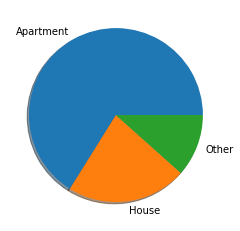

In [25]:
plt.pie((X['property_type'].value_counts() / sum(X['property_type'].value_counts())) * 100, labels = X['property_type'].value_counts().index.tolist(), shadow = True)
plt.show() 

In [26]:
AirBnbTest_X = pd.merge(AirBnbTest_X,dfForPropertyType,on='property_type',how='left')
AirBnbTest_X['property_type'] = np.where(AirBnbTest_X['Value_Counts'] < 3000 , 'Other', AirBnbTest_X['property_type'])
AirBnbTest_X = AirBnbTest_X.drop(['Value_Counts'],axis = 1)

In [27]:
for i, col in enumerate(X['amenities']):
    X['amenities'].iloc[i] = re.sub('translation missing*@', '', X['amenities'].iloc[i])
    X['amenities'].iloc[i] = re.sub('[^.,a-zA-Z]', '',X['amenities'].iloc[i])
    X['amenities'].iloc[i] = re.sub('translationmissingen.hostingamenity', '', X['amenities'].iloc[i])
    X['amenities'].iloc[i] = re.sub(',', ' ', X['amenities'].iloc[i])
vectorizer = CountVectorizer()
X_Vec = vectorizer.fit_transform(X['amenities'])
df1 = pd.DataFrame(X_Vec.toarray(), columns=vectorizer.get_feature_names())
dfForAmenities = pd.DataFrame(columns = ['amenities','Value_Counts'])
idx = 0
for col in df1.columns:
    colSum = df1[col].sum()
    df1[col].loc[df1[col] == 1] = colSum
    dfForAmenities.loc[idx] = [col,colSum]
    idx+=1
X['amenities'] = df1.sum(axis = 1)

In [28]:
for i, col in enumerate(AirBnbTest_X['amenities']):
    AirBnbTest_X['amenities'].iloc[i] = re.sub('translation missing*@', '', AirBnbTest_X['amenities'].iloc[i])
    AirBnbTest_X['amenities'].iloc[i] = re.sub('[^.,a-zA-Z]', '',AirBnbTest_X['amenities'].iloc[i])
    AirBnbTest_X['amenities'].iloc[i] = re.sub('translationmissingen.hostingamenity', '', AirBnbTest_X['amenities'].iloc[i])
    AirBnbTest_X['amenities'].iloc[i] = re.sub(',', ' ', AirBnbTest_X['amenities'].iloc[i])
vectorizer = CountVectorizer()
X_Vec = vectorizer.fit_transform(AirBnbTest_X['amenities'])
df2 = pd.DataFrame(X_Vec.toarray(), columns=vectorizer.get_feature_names())
idx = 0
for col in df2.columns:
    df2[col].loc[df2[col] == 1] = int(dfForAmenities[dfForAmenities['amenities'] == col]['Value_Counts'].to_string(index=False))


In [29]:
AirBnbTest_X['amenities'] = df2.sum(axis = 1)  

In [30]:
cachedStopWords = stopwords.words("english")
def removeStopWords(text):
    text = re.sub(r'[^A-Za-z\' ]+','',text)
    a =  ' '.join([word for word in text.split() if word.lower() not in cachedStopWords])
    return a
X['description'] = X['description'].apply(removeStopWords)
X['description'] = X['description'].apply(lambda x: (TextBlob(x).sentiment.polarity))

In [31]:
for i, col in enumerate(AirBnbTest_X['description']):
    if not pd.isna(AirBnbTest_X['description'].iloc[i]):
        AirBnbTest_X['description'].loc[i] = removeStopWords(AirBnbTest_X['description'].loc[i])
        AirBnbTest_X['description'].iloc[i] = TextBlob(AirBnbTest_X['description'].iloc[i]).sentiment.polarity

In [32]:
for i, col in enumerate(X['host_response_rate']):
    if not pd.isna(X['host_response_rate'].iloc[i]):
        X['host_response_rate'].iloc[i] =  re.sub('%*', '', X['host_response_rate'].iloc[i])
X['host_response_rate'] = pd.to_numeric(X['host_response_rate'])

In [33]:
for i, col in enumerate(AirBnbTest_X['host_response_rate']):
    if not pd.isna(AirBnbTest_X['host_response_rate'].iloc[i]):
        AirBnbTest_X['host_response_rate'].iloc[i] =  re.sub('%*', '', AirBnbTest_X['host_response_rate'].iloc[i])
AirBnbTest_X['host_response_rate'] = pd.to_numeric(AirBnbTest_X['host_response_rate'])

In [34]:
X[['first_review','last_review','host_since']] = X[['first_review','last_review','host_since']].apply(pd.to_datetime)
X['review_diff'] = (X['last_review'] - X['first_review']).dt.days
X['host_since'] = X['host_since'].apply(lambda x : (pd.to_datetime(date.today()) - x)).dt.days

In [35]:
AirBnbTest_X[['first_review','last_review','host_since']] = AirBnbTest_X[['first_review','last_review','host_since']].apply(pd.to_datetime)
AirBnbTest_X['review_diff'] = (AirBnbTest_X['last_review'] - AirBnbTest_X['first_review']).dt.days
AirBnbTest_X['host_since'] = AirBnbTest_X['host_since'].apply(lambda x : (pd.to_datetime(date.today()) - x)).dt.days

In [36]:
def drawPlot(data):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sbs.distplot(data, ax=ax)

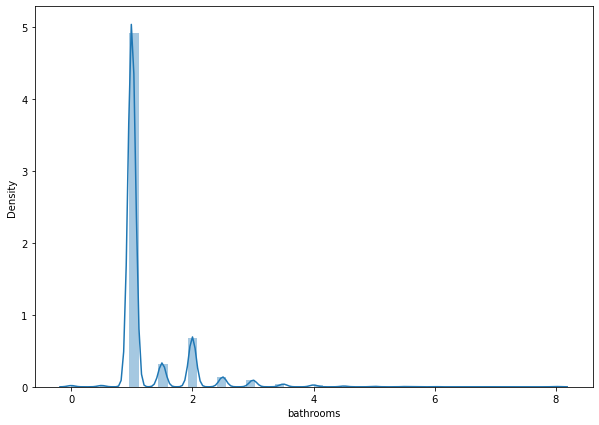

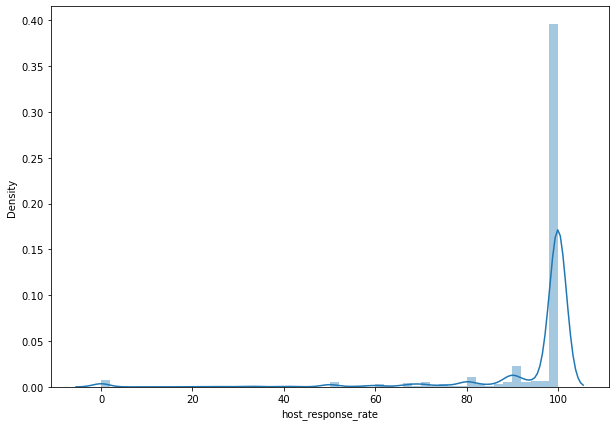

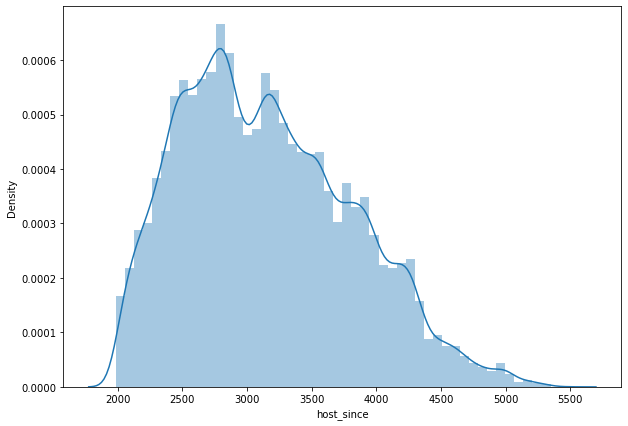

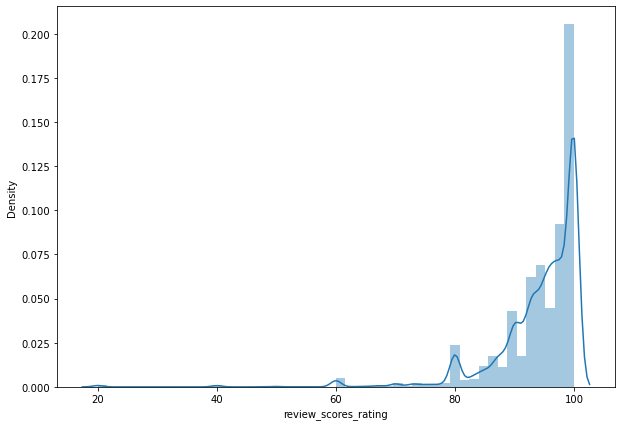

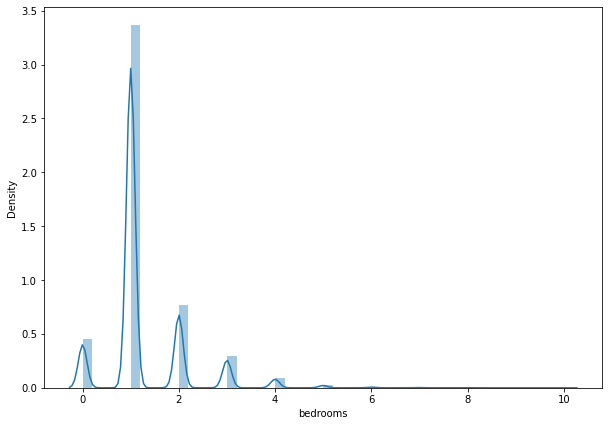

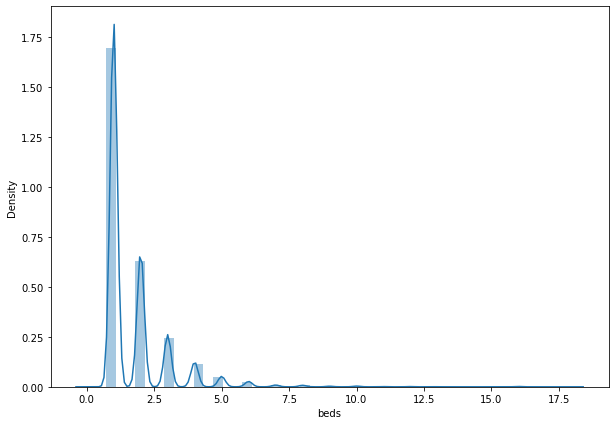

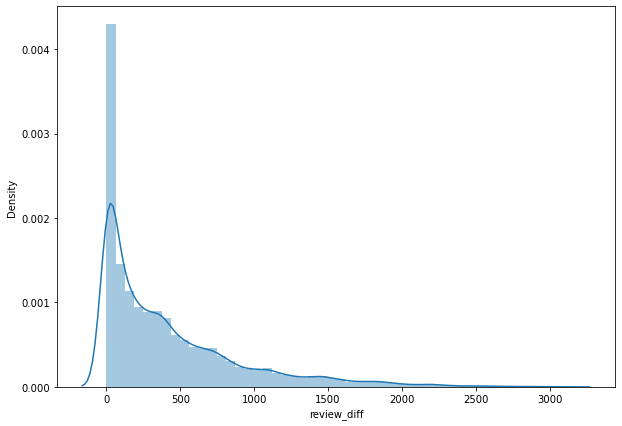

In [37]:
drawPlot(X["bathrooms"])
drawPlot(X["host_response_rate"])
drawPlot(X["host_since"])
drawPlot(X["review_scores_rating"])
drawPlot(X["bedrooms"])
drawPlot(X["beds"])
drawPlot(X["review_diff"]) 

In [38]:
X['host_has_profile_pic'] = X['host_has_profile_pic'].fillna(X['host_has_profile_pic'].mode()[0])
X['host_identity_verified'] = X['host_identity_verified'].fillna(X['host_identity_verified'].mode()[0])
X['host_response_rate'] = X['host_response_rate'].fillna(X['host_response_rate'].median())
X['bathrooms'] = X['bathrooms'].fillna(X['bathrooms'].median())
X['review_scores_rating'] = X['review_scores_rating'].fillna(X['review_scores_rating'].median())
X['bedrooms'] = X['bedrooms'].fillna(X['bedrooms'].median())
X['host_since'] = X['host_since'].fillna(X['host_since'].median())
X['beds'] = X['beds'].fillna(X['beds'].median())
X['review_diff'] = X['review_diff'].fillna(X['review_diff'].median())
X['zipcode'] = X['zipcode'].fillna(X['zipcode'].median())

In [39]:
for i, col in enumerate(AirBnbTest_X['neighbourhood']):
    if pd.isna(AirBnbTest_X['neighbourhood'].iloc[i]):
        if len(AirBnbTest_X[(AirBnbTest_X['zipcode'].iloc[i] ==AirBnbTest_X['zipcode']) & (AirBnbTest_X['city'].iloc[i] == AirBnbTest_X['city'])].neighbourhood.mode(dropna = True)) > 0:
            AirBnbTest_X['neighbourhood'].iloc[i] = AirBnbTest_X[(AirBnbTest_X['zipcode'].iloc[i] == AirBnbTest_X['zipcode']) & (AirBnbTest_X['city'].iloc[i] == AirBnbTest_X['city'])].neighbourhood.mode(dropna = True)[0]
        elif len(AirBnbTest_X[AirBnbTest_X['zipcode'].iloc[i] == AirBnbTest_X['zipcode']].neighbourhood.mode(dropna = True)) > 0:
            AirBnbTest_X['neighbourhood'].iloc[i] = AirBnbTest_X[AirBnbTest_X['zipcode'].iloc[i] == AirBnbTest_X['zipcode']].neighbourhood.mode(dropna = True)[0]
        else:
            AirBnbTest_X['neighbourhood'].iloc[i] = AirBnbTest_X[AirBnbTest_X['city'].iloc[i] == AirBnbTest_X['city']].neighbourhood.mode(dropna = True)[0]

In [40]:
AirBnbTest_X['host_has_profile_pic'] = AirBnbTest_X['host_has_profile_pic'].fillna(X['host_has_profile_pic'].mode()[0])
AirBnbTest_X['host_identity_verified'] = AirBnbTest_X['host_identity_verified'].fillna(X['host_identity_verified'].mode()[0])
AirBnbTest_X['host_response_rate'] = AirBnbTest_X['host_response_rate'].fillna(X['host_response_rate'].median())
AirBnbTest_X['bathrooms'] = AirBnbTest_X['bathrooms'].fillna(X['bathrooms'].median())
AirBnbTest_X['review_scores_rating'] = AirBnbTest_X['review_scores_rating'].fillna(X['review_scores_rating'].median())
AirBnbTest_X['bedrooms'] = AirBnbTest_X['bedrooms'].fillna(X['bedrooms'].median())
AirBnbTest_X['host_since'] = AirBnbTest_X['host_since'].fillna(X['host_since'].median())
AirBnbTest_X['beds'] = AirBnbTest_X['beds'].fillna(X['beds'].median())
AirBnbTest_X['review_diff'] = AirBnbTest_X['review_diff'].fillna(X['review_diff'].median())
AirBnbTest_X['zipcode'] = AirBnbTest_X['zipcode'].fillna(X['zipcode'].median())
AirBnbTest_X['description'] = AirBnbTest_X['description'].fillna(0)

In [41]:
X = X.drop(["first_review","last_review","longitude","latitude"],axis = 1)
AirBnbTest_X = AirBnbTest_X.drop(["first_review","last_review","longitude","latitude"],axis = 1)

In [42]:
dfForBedType = pd.DataFrame(columns = ['bed_type','Value_Counts'])
for idx, name in enumerate(X['bed_type'].value_counts().index.tolist()):
    dfForBedType.loc[idx] = [name,X['bed_type'].value_counts()[idx]]
X = pd.merge(X,dfForBedType,on='bed_type',how='left')
X['bed_type'] = np.where(X['Value_Counts'] < 1000 , 'Other', X['bed_type'])
X = X.drop(['Value_Counts'],axis = 1)

In [43]:
(X['bed_type'].value_counts() / sum(X['bed_type'].value_counts())) * 100

Real Bed    97.189351
Other        2.810649
Name: bed_type, dtype: float64

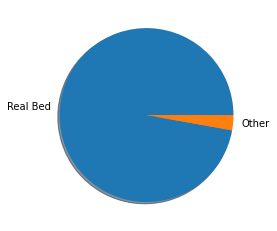

In [44]:
plt.pie((X['bed_type'].value_counts() / sum(X['bed_type'].value_counts())) * 100, labels = X['bed_type'].value_counts().index.tolist(), shadow = True)
plt.show() 

In [45]:
AirBnbTest_X = pd.merge(AirBnbTest_X,dfForBedType,on='bed_type',how='left')
AirBnbTest_X['bed_type'] = np.where(AirBnbTest_X['Value_Counts'] < 1000 , 'Other', AirBnbTest_X['bed_type'])
AirBnbTest_X = AirBnbTest_X.drop(['Value_Counts'],axis = 1)

In [46]:
dfForCity = pd.DataFrame(columns = ['city','Value_Counts'])
for idx, name in enumerate(X['city'].value_counts().index.tolist()):
    dfForCity.loc[idx] = [name,X['city'].value_counts()[idx]]
X = pd.merge(X,dfForCity,on='city',how='left')
X['city'] = np.where(X['Value_Counts'] < 7000 , 'Other', X['city'])
X = X.drop(['Value_Counts'],axis = 1)

In [47]:
(X['city'].value_counts() / sum(X['city'].value_counts())) * 100

NYC      43.649391
LA       30.296447
Other    26.054162
Name: city, dtype: float64

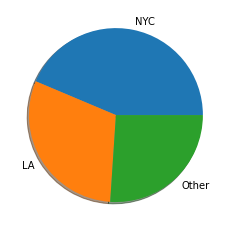

In [48]:
plt.pie((X['city'].value_counts() / sum(X['city'].value_counts())) * 100, labels = X['city'].value_counts().index.tolist(), shadow = True)
plt.show() 

In [49]:
AirBnbTest_X = pd.merge(AirBnbTest_X,dfForCity,on='city',how='left')
AirBnbTest_X['city'] = np.where(AirBnbTest_X['Value_Counts'] < 7000 , 'Other', AirBnbTest_X['city'])
AirBnbTest_X = AirBnbTest_X.drop(['Value_Counts'],axis = 1)

In [50]:
# X.to_excel(r'Downloads//XBeforeLabelEncoder.xlsx', index = False)

In [51]:
# AirBnbTest_X.to_excel(r'Downloads//AirBnbTest_XBeforeLabelEncoder.xlsx', index = False)

In [52]:
d = pd.get_dummies(X, columns = ['room_type','bed_type','city','property_type'])
X[d.columns] = d
X = X.drop(['room_type','bed_type','city','property_type'],axis = 1)

In [53]:
d = pd.get_dummies(AirBnbTest_X, columns = ['room_type','bed_type','city','property_type'])
AirBnbTest_X[d.columns] = d
AirBnbTest_X = AirBnbTest_X.drop(['room_type','bed_type','city','property_type'],axis = 1)

In [54]:
cols = ['cancellation_policy','cleaning_fee','host_has_profile_pic','host_identity_verified','instant_bookable']
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(X[c].values))
    le_dict = dict(zip(lbl.classes_, lbl.transform(lbl.classes_)))
    print(le_dict)
    X[c] = lbl.transform(list(X[c].values))
    AirBnbTest_X[c] = AirBnbTest_X[c].apply(lambda x: le_dict.get(x) if le_dict.get(x) != None else np.nan)

{'flexible': 0, 'moderate': 1, 'strict': 2, 'super_strict_30': 3, 'super_strict_60': 4}
{False: 0, True: 1}
{'f': 0, 't': 1}
{'f': 0, 't': 1}
{'f': 0, 't': 1}


In [55]:
AirBnbTest_X['cancellation_policy'] = AirBnbTest_X['cancellation_policy'].fillna(X['cancellation_policy'].mode())

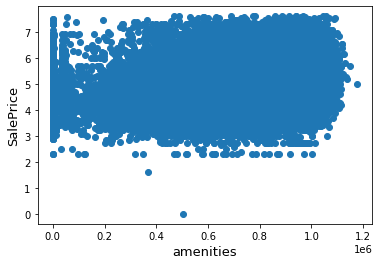

In [56]:
fig, ax = plt.subplots()
ax.scatter(x = X['amenities'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('amenities', fontsize=13)
plt.show()

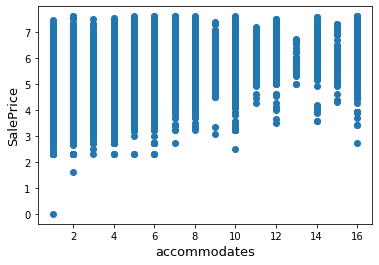

In [57]:
fig, ax = plt.subplots()
ax.scatter(x = X['accommodates'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('accommodates', fontsize=13)
plt.show()

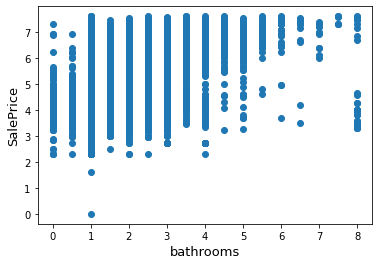

In [58]:
fig, ax = plt.subplots()
ax.scatter(x = X['bathrooms'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('bathrooms', fontsize=13)
plt.show()

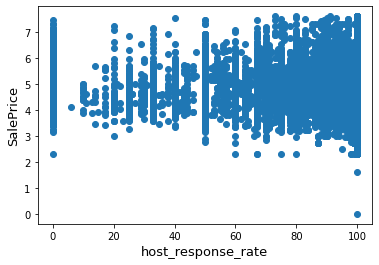

In [59]:
fig, ax = plt.subplots()
ax.scatter(x = X['host_response_rate'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('host_response_rate', fontsize=13)
plt.show()

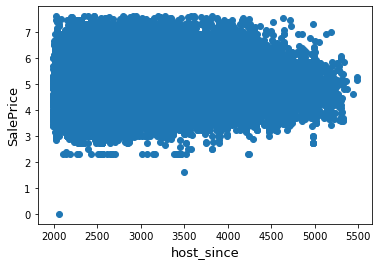

In [60]:
fig, ax = plt.subplots()
ax.scatter(x = X['host_since'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('host_since', fontsize=13)
plt.show()

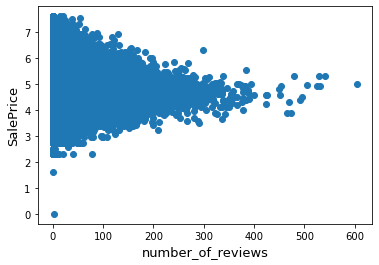

In [61]:
fig, ax = plt.subplots()
ax.scatter(x = X['number_of_reviews'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('number_of_reviews', fontsize=13)
plt.show()

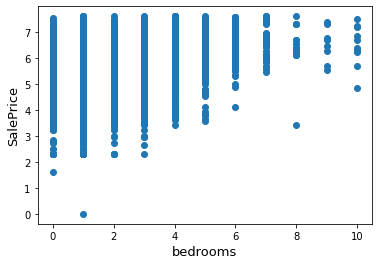

In [62]:
fig, ax = plt.subplots()
ax.scatter(x = X['bedrooms'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('bedrooms', fontsize=13)
plt.show()

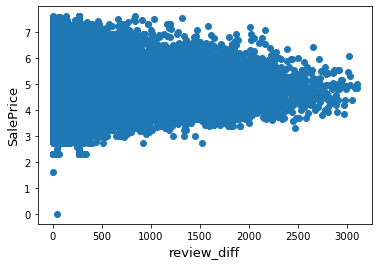

In [63]:
fig, ax = plt.subplots()
ax.scatter(x = X['review_diff'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('review_diff', fontsize=13)
plt.show()

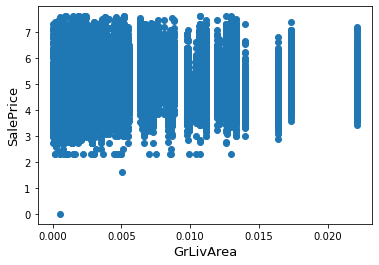

In [64]:
fig, ax = plt.subplots()
ax.scatter(x = X['zipcode'], y = Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [65]:
scaler = preprocessing.MinMaxScaler()
names = ['amenities','host_since','accommodates','number_of_reviews','review_scores_rating','beds','review_diff','host_response_rate']
d = scaler.fit_transform(X[names])
X[names] = pd.DataFrame(d,columns = names)
d = scaler.transform(AirBnbTest_X[names])
AirBnbTest_X[names] = pd.DataFrame(d,columns = names)

In [66]:
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k = 1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any (upper_tri[column] > 0.80)]
X = X.drop(X[to_drop],axis = 1)
AirBnbTest_X = AirBnbTest_X.drop(AirBnbTest_X[to_drop],axis = 1)

In [67]:
to_drop

['beds', 'room_type_Private room', 'bed_type_Real Bed']

In [68]:
corr_matrix = AirBnbTest_X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k = 1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any (upper_tri[column] > 0.80)]

In [69]:
to_drop

[]

In [70]:
# X.to_excel(r'Downloads//X.xlsx', index = False)

In [71]:
# AirBnbTest_X.to_excel(r'Downloads//AirBnbTest_X.xlsx', index = False)

In [72]:
trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.5, random_state = 45)

In [73]:
ridge = Ridge()
ridge.fit(trainX,trainY)
predY = ridge.predict(trainX)
print(np.sqrt(mean_squared_error(trainY,predY)))
ridge.score(trainX,trainY)

0.4862833311650583


0.544051668024663

In [74]:
def two_score(Y,Y_pred, scaler = None):
     return  mean_squared_error(Y, Y_pred)
#       r2Score = r2_score(Y,Y_pred)
#       return r2Score

two_scorer =  make_scorer(two_score, greater_is_better=False)

# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['alpha'] = np.linspace(0.1,50,100)
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
space['solver'] = ['auto', 'cholesky','saga']
search = RandomizedSearchCV(model, space, scoring=two_scorer, n_jobs=-1, cv=cv, verbose = 2)
result = search.fit(trainX,trainY)
print(result)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   12.2s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=Ridge(), n_jobs=-1,
                   param_distributions={'alpha': array([ 0.1       ,  0.6040404 ,  1.10808081,  1.61212121,  2.11616162,
        2.62020202,  3.12424242,  3.62828283,  4.13232323,  4.63636364,
        5.14040404,  5.64444444,  6.14848485,  6.65252525,  7.15656566,
        7.66060606,  8.16464646,  8.66868687,  9.17272727,  9.6767676...
       40.42323232, 40.92727273, 41.43131313, 41.93535354, 42.43939394,
       42.94343434, 43.44747475, 43.95151515, 44.45555556, 44.95959596,
       45.46363636, 45.96767677, 46.47171717, 46.97575758, 47.47979798,
       47.98383838, 48.48787879, 48.99191919, 49.4959596 , 50.        ]),
                                        'fit_intercept': [True, False],
                                        'normalize': [True, False],
                                        'solver': ['auto', 'cholesky', 'saga']},
                   scor

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.9s finished


In [75]:
ridge = Ridge(alpha = result.best_params_['alpha'], fit_intercept = result.best_params_['fit_intercept'], normalize = result.best_params_['normalize'], solver = result.best_params_['solver'])
ridge.fit(trainX,trainY)
predY = ridge.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(ridge.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-ridge.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = ridge.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(ridge.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-ridge.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.48683267397385904
r2: 0.5430209380061173
adjusted r2: 0.5427000604104643
Testing Score
rmse: 0.48731911406553735
r2: 0.534949896457547
adjusted r2: 0.5346233604265415


In [76]:
rfe = RFECV(estimator=Ridge(alpha = result.best_params_['alpha'], fit_intercept = result.best_params_['fit_intercept'], normalize = result.best_params_['normalize'], solver = result.best_params_['solver']))
rfe.fit(trainX, trainY)
for i in range(trainX.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (trainX.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: amenities, Selected True, Rank: 1.000
Column: accommodates, Selected True, Rank: 1.000
Column: bathrooms, Selected True, Rank: 1.000
Column: cancellation_policy, Selected False, Rank: 6.000
Column: cleaning_fee, Selected True, Rank: 1.000
Column: description, Selected True, Rank: 1.000
Column: host_has_profile_pic, Selected True, Rank: 1.000
Column: host_identity_verified, Selected True, Rank: 1.000
Column: host_response_rate, Selected True, Rank: 1.000
Column: host_since, Selected True, Rank: 1.000
Column: instant_bookable, Selected True, Rank: 1.000
Column: neighbourhood, Selected True, Rank: 1.000
Column: number_of_reviews, Selected True, Rank: 1.000
Column: review_scores_rating, Selected True, Rank: 1.000
Column: zipcode, Selected True, Rank: 1.000
Column: bedrooms, Selected True, Rank: 1.000
Column: review_diff, Selected True, Rank: 1.000
Column: room_type_Entire home/apt, Selected True, Rank: 1.000
Column: room_type_Shared room, Selected True, Rank: 1.000
Column: bed_type

In [77]:
for i in trainX.columns[rfe.support_ == False]:
    trainX = trainX.drop([i],axis = 1)
    testX = testX.drop([i],axis = 1)

In [78]:
ridge = Ridge(alpha = result.best_params_['alpha'], fit_intercept = result.best_params_['fit_intercept'], normalize = result.best_params_['normalize'], solver = result.best_params_['solver'])
ridge.fit(trainX,trainY)
predY = ridge.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(ridge.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-ridge.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = ridge.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(ridge.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-ridge.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.4868501458144463
r2: 0.5429881365569847
adjusted r2: 0.5427289825826294
Testing Score
rmse: 0.48734189901620584
r2: 0.5349064079463154
adjusted r2: 0.5346426782537861


In [79]:
trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.5, random_state = 45)

In [80]:
lr = LinearRegression()
lr.fit(trainX,trainY)
predY = lr.predict(trainX)
print(np.sqrt(mean_squared_error(trainY,predY)))
lr.score(trainX,trainY)
print("Testing Score")
predTestY = lr.predict(testX)
print(np.sqrt(mean_squared_error(testY,predTestY)))
lr.score(testX,testY)

0.48472274664905063
Testing Score
0.48562029333324447


0.5381866244220461

In [81]:
rfe = RFECV(estimator=LinearRegression())
rfe.fit(trainX, trainY)
for i in range(trainX.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (trainX.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: amenities, Selected True, Rank: 1.000
Column: accommodates, Selected True, Rank: 1.000
Column: bathrooms, Selected True, Rank: 1.000
Column: cancellation_policy, Selected False, Rank: 5.000
Column: cleaning_fee, Selected True, Rank: 1.000
Column: description, Selected True, Rank: 1.000
Column: host_has_profile_pic, Selected True, Rank: 1.000
Column: host_identity_verified, Selected True, Rank: 1.000
Column: host_response_rate, Selected True, Rank: 1.000
Column: host_since, Selected True, Rank: 1.000
Column: instant_bookable, Selected True, Rank: 1.000
Column: neighbourhood, Selected True, Rank: 1.000
Column: number_of_reviews, Selected True, Rank: 1.000
Column: review_scores_rating, Selected True, Rank: 1.000
Column: zipcode, Selected True, Rank: 1.000
Column: bedrooms, Selected True, Rank: 1.000
Column: review_diff, Selected True, Rank: 1.000
Column: room_type_Entire home/apt, Selected True, Rank: 1.000
Column: room_type_Shared room, Selected True, Rank: 1.000
Column: bed_type

In [82]:
for i in trainX.columns[rfe.support_ == False]:
    trainX = trainX.drop([i],axis = 1)
    testX = testX.drop([i],axis = 1)

In [83]:
lr.fit(trainX,trainY)
predY = lr.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(lr.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-lr.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = lr.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(lr.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-lr.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.4847410508839543
r2: 0.5469392232969866
adjusted r2: 0.5466823098330285
Testing Score
rmse: 0.4856328896064845
r2: 0.5381626665974314
adjusted r2: 0.5379007833549663


In [84]:
trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.5, random_state = 45)

In [85]:
lasso = Lasso()
lasso.fit(trainX,trainY)
predY = lasso.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(lasso.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-lasso.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = lasso.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(lasso.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-lasso.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.720164264729196
r2: 0.0
adjusted r2: -0.0007021713298045462
Testing Score
rmse: 0.714604918451935
r2: -1.1180132927224307e-05
adjusted r2: -0.0007133403501478064


In [86]:
def my_custom_loss_function(Y,Y_pred):
#     r2Score = r2_score(Y,Y_pred)
#     return r2Score
    return mean_squared_error(Y, Y_pred)

my_scorer = make_scorer(my_custom_loss_function,greater_is_better = False)

# define model
model = Lasso()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
# space['selection'] = ['cyclic', 'random']
space['alpha'] = np.logspace(-10,10,100)
# space['fit_intercept'] = [True, False]
# space['normalize'] = [True, False]
# define search
search = GridSearchCV(model, space,  scoring=my_scorer, n_jobs=-1, cv=cv)
# execute search

result = search.fit(trainX,trainY)
# print(result)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.2353417108285684
Best Hyperparameters: {'alpha': 1.0722672220103232e-07}


In [87]:
lasso = Lasso(alpha = result.best_params_['alpha'])
lasso.fit(trainX,trainY)
predY = lasso.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(lasso.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-lasso.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = lasso.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(lasso.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-lasso.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.4847227478809115
r2: 0.5469734362698984
adjusted r2: 0.5466553340052073
Testing Score
rmse: 0.48562003844984997
r2: 0.5381871091980388
adjusted r2: 0.5378628461836217


In [88]:
rfe = RFECV(estimator=Lasso(alpha = result.best_params_['alpha']))
rfe.fit(trainX, trainY)
for i in range(trainX.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (trainX.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: amenities, Selected True, Rank: 1.000
Column: accommodates, Selected True, Rank: 1.000
Column: bathrooms, Selected True, Rank: 1.000
Column: cancellation_policy, Selected False, Rank: 5.000
Column: cleaning_fee, Selected True, Rank: 1.000
Column: description, Selected True, Rank: 1.000
Column: host_has_profile_pic, Selected True, Rank: 1.000
Column: host_identity_verified, Selected True, Rank: 1.000
Column: host_response_rate, Selected True, Rank: 1.000
Column: host_since, Selected True, Rank: 1.000
Column: instant_bookable, Selected True, Rank: 1.000
Column: neighbourhood, Selected True, Rank: 1.000
Column: number_of_reviews, Selected True, Rank: 1.000
Column: review_scores_rating, Selected True, Rank: 1.000
Column: zipcode, Selected True, Rank: 1.000
Column: bedrooms, Selected True, Rank: 1.000
Column: review_diff, Selected True, Rank: 1.000
Column: room_type_Entire home/apt, Selected True, Rank: 1.000
Column: room_type_Shared room, Selected True, Rank: 1.000
Column: bed_type

In [89]:
for i in trainX.columns[rfe.support_ == False]:
    trainX = trainX.drop([i],axis = 1)
    testX = testX.drop([i],axis = 1)

In [90]:
lasso = Lasso(alpha = result.best_params_['alpha'])
lasso.fit(trainX,trainY)
predY = lasso.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(lasso.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-lasso.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = lasso.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(lasso.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-lasso.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.48474105211527885
r2: 0.5469392209952841
adjusted r2: 0.546670066287515
Testing Score
rmse: 0.48563263574614013
r2: 0.5381631494401562
adjusted r2: 0.5378887884455752


In [91]:
trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.5, random_state = 45)

In [92]:
random = RandomForestRegressor()
random.fit(trainX,trainY)
predY = random.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(random.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-random.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = random.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(random.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-random.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

Training Score
rmse: 0.15832542549242518
r2: 0.9516676187244243
adjusted r2: 0.9516336811119914
Testing Score
rmse: 0.4224855537350769
r2: 0.6504602426806989
adjusted r2: 0.6502148125127143


In [93]:
# AirBnbTestPred = random.predict(AirBnbTest_X)
# AirBnbTest['log_price'] = AirBnbTestPred
# AirBnbTest[['id','log_price']].to_excel(r'Downloads//RandomForestWithoutHyp.xlsx', index = False)

In [94]:
def my_custom_loss_function(Y,Y_pred):
#     r2Score = r2_score(Y,Y_pred)
#     return r2Score
   return mean_squared_error(Y,Y_pred)

my_scorer = make_scorer(my_custom_loss_function,greater_is_better = False)

# define model
model = RandomForestRegressor()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space



# for i in alphas:
space = dict()
space['n_estimators'] = [10,50,100,500,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
# space['criterion'] = ['gini','entropy']
# space['max_depth'] =  list(range(1, 6))
# space['min_samples_leaf'] =  np.linspace(0.1, 0.5,5)
# space['ccp_alpha'] = np.linspace(0,10,50)
# space['min_weight_fraction_leaf'] =  np.linspace(0.1, 0.8,50) 
# space['max_features'] = ['sqrt','log2']
# space['max_leaf_nodes'] =  list(range(2, 10))
# space['min_impurity_decrease'] =  list(range(1,10))
# space['bootstrap'] = [True,False]
# space['max_samples'] = list(range(1, 20))
# define search
search = RandomizedSearchCV(model, param_distributions = space,  scoring=my_scorer, n_jobs=-1, verbose = 2, cv=5, random_state = 6)
# execute search
# search = GridSearchCV(model, space,  scoring=my_scorer, n_jobs=-1, verbose = 2, cv=cv)
result = search.fit(trainX,trainY)
# print(result)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 19.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.9min finished


Best Score: -0.18036996698833874
Best Hyperparameters: {'n_estimators': 1800}


In [ ]:
random = RandomForestRegressor(
    n_estimators = result.best_params_['n_estimators']
#     ,
#                                max_depth = result.best_params_['max_depth'], 
#                                 min_samples_leaf = result.best_params_['min_samples_leaf'],
#                               ccp_alpha = result.best_params_['ccp_alpha']
#     ,
#                                 min_weight_fraction_leaf = result.best_params_['min_weight_fraction_leaf']
#                                max_leaf_nodes = result.best_params_['max_leaf_nodes'],
#                                 max_features = result.best_params_['max_features']
#                                min_impurity_decrease = result.best_params_['min_impurity_decrease'],
#                                bootstrap = result.best_params_['bootstrap'],
#                                max_samples = result.best_params_['max_samples']
                              )
random.fit(trainX,trainY)
predY = random.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(random.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-random.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = random.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(random.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-random.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

In [ ]:
rfe = RFECV(estimator=RandomForestRegressor(
    n_estimators = result.best_params_['n_estimators']
#                             max_depth = result.best_params_['max_depth'], 
#                                 min_samples_leaf = result.best_params_['min_samples_leaf'],
#                               ccp_alpha = result.best_params_['ccp_alpha'], 
#                                min_weight_fraction_leaf = result.best_params_['min_weight_fraction_leaf'],
#                                max_leaf_nodes = result.best_params_['max_leaf_nodes'],
#                                 max_features = result.best_params_['max_features'],
#                                min_impurity_decrease = result.best_params_['min_impurity_decrease'],
#                              bootstrap = result.best_params_['bootstrap'],
#                                 max_samples = result.best_params_['max_samples']
                              ))
rfe.fit(trainX, trainY)
for i in range(trainX.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (trainX.columns[i], rfe.support_[i], rfe.ranking_[i]))

In [ ]:
for i in trainX.columns[rfe.support_ == False]:
    trainX = trainX.drop([i],axis = 1)
    testX = testX.drop([i],axis = 1)
#     AirBnbTest_X = AirBnbTest_X.drop([i],axis = 1)

In [ ]:
random = RandomForestRegressor(
    n_estimators = result.best_params_['n_estimators']
#     ,
#                               max_depth = result.best_params_['max_depth'], 
#                                  min_samples_leaf = result.best_params_['min_samples_leaf'],
#                               ccp_alpha = result.best_params_['ccp_alpha'], 
#                                min_weight_fraction_leaf = result.best_params_['min_weight_fraction_leaf'],
#                                max_leaf_nodes = result.best_params_['max_leaf_nodes'],
# #                                max_features = result.best_params_['max_features'],
# #                                min_impurity_decrease = result.best_params_['min_impurity_decrease'],
# #                                bootstrap = result.best_params_['bootstrap'],
#                             max_samples = result.best_params_['max_samples']
                              )
random.fit(trainX,trainY)
predY = random.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(random.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-random.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = random.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(random.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-random.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

In [ ]:
# AirBnbTestPred = random.predict(AirBnbTest_X)
# AirBnbTest['log_price'] = AirBnbTestPred
# AirBnbTest[['id','log_price']].to_excel(r'Downloads//RandomForestWithHyp.xlsx', index = False)

In [ ]:
# trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.5, random_state = 456)
trainX,testX,trainY,testY = train_test_split(X,Y,test_size = 0.5)

In [ ]:
model = xgb.XGBRegressor()
model.fit(trainX,trainY)
predY = model.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(model.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-model.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = model.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(model.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-model.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

In [ ]:
def my_custom_loss_function(Y,Y_pred):
#     r2Score = r2_score(Y,Y_pred)
#     return r2Score
   return np.sqrt(mean_squared_error(Y,Y_pred))

my_scorer = make_scorer(my_custom_loss_function,greater_is_better = False)

# define model
model = xgb.XGBRegressor()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
# for i in alphas:
space = dict()
space['n_estimators'] = [800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]
# space['min_child_weight'] =  np.linspace(0.01,1,40)
space['eta'] = np.linspace(0.01,0.4,80)
space['max_depth'] = list(range(1, 8))
# space['max_features'] = ['sqrt','log2']
# space['max_leaf_nodes'] =  list(range(2, 10))
space['alpha'] = np.linspace(0,5,100)
# space['max_samples'] = list(range(1, 20))
# define search
search = RandomizedSearchCV(model, param_distributions = space,  scoring=my_scorer, verbose = 2, cv=5, random_state = 60)
# execute search
# search = GridSearchCV(model, space,  scoring=my_scorer, n_jobs=-1, verbose = 2, cv=cv)
result = search.fit(trainX,trainY)
# print(result)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
model = xgb.XGBRegressor(
    eta = result.best_params_['eta'],
                             max_depth = result.best_params_['max_depth'], 
                            alpha = result.best_params_['alpha'], 
                              n_estimators = result.best_params_['n_estimators']
#     ,
#                                max_leaf_nodes = result.best_params_['max_leaf_nodes'],
#                         min_child_weight = result.best_params_['min_child_weight'],
#                         max_samples = result.best_params_['max_samples']
)
# model.fit(trainX,trainY,eval_metric="rmse",eval_set=[(testX,testY)]

model.fit(trainX,trainY)
predY = model.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(model.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-model.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = model.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(model.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-model.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

In [ ]:
rfe = RFECV(xgb.XGBRegressor(
eta = result.best_params_['eta'],
                             max_depth = result.best_params_['max_depth'], 
                            alpha = result.best_params_['alpha'], 
                              n_estimators = result.best_params_['n_estimators']
#     ,
#                                max_leaf_nodes = result.best_params_['max_leaf_nodes'],
#                         min_child_weight = result.best_params_['min_child_weight'],
#                         max_samples = result.best_params_['max_samples']
)
)
rfe.fit(trainX, trainY)
for i in range(trainX.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (trainX.columns[i], rfe.support_[i], rfe.ranking_[i]))

In [ ]:
for i in trainX.columns[rfe.support_ == False]:
    trainX = trainX.drop([i],axis = 1)
    testX = testX.drop([i],axis = 1)
    AirBnbTest_X = AirBnbTest_X.drop([i],axis = 1)

In [ ]:
model = xgb.XGBRegressor(
eta = result.best_params_['eta'],
                             max_depth = result.best_params_['max_depth'], 
                            alpha = result.best_params_['alpha'], 
                              n_estimators = result.best_params_['n_estimators']
#     ,
#                                max_leaf_nodes = result.best_params_['max_leaf_nodes'],
#                         min_child_weight = result.best_params_['min_child_weight'],
#                         max_samples = result.best_params_['max_samples']
# model.fit(trainX,trainY,early_stopping_rounds=100,eval_metric="rmse",eval_set=[(testX,testY)]
)
model.fit(trainX,trainY)
predY = model.predict(trainX)
print("Training Score")
print("rmse: " + str(np.sqrt(mean_squared_error(trainY,predY))))
print("r2: " + str(model.score(trainX,trainY)))
print("adjusted r2: " + str(1 - (1-model.score(trainX, trainY))*(len(trainY)-1)/(len(trainY)-trainX.shape[1]-1)))
print("Testing Score")
predTestY = model.predict(testX)
print("rmse: " + str(np.sqrt(mean_squared_error(testY,predTestY))))
print("r2: " + str(model.score(testX,testY)))
print("adjusted r2: " + str(1 - (1-model.score(testX, testY))*(len(testY)-1)/(len(testY)-testX.shape[1]-1)))

In [ ]:
AirBnbTestPred = model.predict(AirBnbTest_X)
AirBnbTest['log_price'] = AirBnbTestPred
AirBnbTest[['id','log_price']].to_excel(r'Downloads//XgBoost.xlsx', index = False)